In [12]:
import numpy as np
import numpy.random as npr

import matplotlib.pyplot as plt
from tqdm.auto import trange 

import ssm
from ssm.messages import hmm_sample

from joblib import Parallel, delayed
import multiprocessing
NumThread=(multiprocessing.cpu_count()-1)*2 # sets number of workers based on cpus on current machine
print('Parallel processing with '+str(NumThread)+' cores')

# from util_factorial_hmm import gibbs

Parallel processing with 18 cores


# Sample synthetic data

In [14]:
num_factors = 2
num_states = 2
emission_dim = 10

hypers = dict(num_factors=num_factors,
              num_states=num_states,
              emission_dim=emission_dim)

num_timesteps = 2000

initial_dist = np.ones((num_factors, num_states)) / num_states
transition_matrix = 0.9 * np.eye(num_states) + 0.1 * np.roll(np.eye(num_states), 1, axis=1)
transition_matrices = np.tile(transition_matrix, (num_factors, 1, 1))

means = 3 * npr.randn(num_factors, num_states, emission_dim)
# means = np.zeros((num_factors, num_states, emission_dim))
# means[1] = npr.gamma(10.0, 1.0, size=(num_states, emission_dim))
# variances = 0.1 * np.ones((num_factors, num_states, emission_dim))
variances=0.5*np.ones(emission_dim)

params = dict(initial_dist=initial_dist,
              transition_matrices=transition_matrices,
              means=means,
              variances=variances)

true_states = np.zeros((num_timesteps, num_factors), dtype=int)
emissions = np.zeros((num_timesteps, emission_dim))
expec_emissions = np.zeros((num_timesteps, emission_dim))

npr.seed(0)
for t in range(num_timesteps):
    for h in range(num_factors):
        if t > 0:
            true_states[t, h] = \
              npr.choice(num_states, p=transition_matrices[h, true_states[t-1, h]])
        
    # mean = np.zeros(emission_dim)
    # for h in range(num_factors):      
    #     mean += means[h, states[t,h], :]
    expec_emissions[t] = np.sum(means[np.arange(num_factors), true_states[t]], axis=0)
    emissions[t] = expec_emissions[t] + np.sqrt(variances) * npr.randn(emission_dim)

(300.0, 400.0)

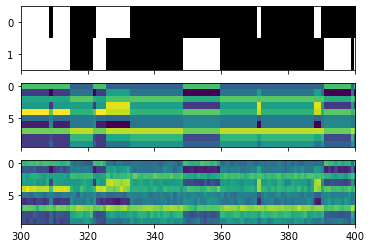

In [15]:
fig, axs = plt.subplots(3, 1, sharex=True)
axs[0].imshow(true_states.T, aspect="auto", interpolation="none", cmap="Greys")
axs[1].imshow(expec_emissions.T, aspect="auto", interpolation="none")
axs[2].imshow(emissions.T, aspect="auto", interpolation="none")

# axs[3].imshow(mean, aspect="auto", interpolation="none")

plt.xlim(300, 400)

# Inference via Gibbs sampling

Let $z_{t,h} \in \{1,\ldots,K\}$ be the state of factor $h$ at time $t$. The emissions are,

\begin{align}
x_{t,n} \sim N(\sum_h \mu_{h,z_{t,h},n}, \sum_h \sigma_{h,z_{t,h},n}^2)
\end{align}

However, we restrict to a simpler model where *all states from all factors* share the same variance $\sigma_{h,z_{t,h},n}^2=\sigma_{n}^2$

\begin{align}
x_{t,n} \sim N(\sum_h \mu_{h,z_{t,h},n}, \sigma_{n}^2)
\end{align}

We perform inference following (Ghahramani and Jordan, 1997), where we use Gibbs sampling to estimate the posterior probabilities, but an exact M-step to obtain the parameters from the posterior probabilities. See Murphy "Machine Learning" book for a variational mean field approximation. 


In [20]:

from scipy.stats import norm




def _m_step(gammat_gibbs,states_outer_gibbs, trans_gibbs,emissions, params, hypers):
    """
    Find parameters with exact M-step using state probabilities estimated from Gibbs sampling 
    """
    num_factors = hypers["num_factors"]
    num_states = hypers["num_states"]
    emission_dim = emissions.shape[1]
    num_timesteps = gammat_gibbs.shape[0]
    params_sample=params.copy()

    # initial state probabilities
    params_sample["initial_dist"]=gammat_gibbs[0,:,:].T
    aa=np.sum(gammat_gibbs[1:],axis=0) + 1e-32
    transition_matrix=np.nan_to_num(np.sum(trans_gibbs,axis=0)/aa)
    transition_matrix=np.transpose(transition_matrix,(2,0,1))
    for h in range(num_factors):
        P = transition_matrix[h]
        P = np.where(P.sum(axis=0, keepdims=True) == 0, 1.0 / num_states, P)
        transition_matrix[h]=P
    # print(transition_matrix)
    params_sample['transition_matrices']=transition_matrix
    # means
    # reshape arrays for convenience
    gammat_re=np.reshape(gammat_gibbs,(num_timesteps,num_factors*num_states))
    states_outer_gibbs_re=np.reshape(np.transpose(states_outer_gibbs,(0,1,3,2,4)),(num_timesteps,num_states*num_factors,num_factors*num_states))
    means_first=np.matmul(emissions.T,gammat_re) # emission_dim x num_states*num_factors
    means_second=np.sum(states_outer_gibbs_re,axis=0) # num_states*num_factors  x num_states*num_factors
    # # check that means_second is symmetric
    # a=means_second-means_second.T
    # print("means_second is symmetric up to "+str(a.max()))

    means_second_inv=np.linalg.pinv(means_second)
    # # check that means_second is symmetric
    # a=means_second_inv-means_second_inv.T
    # print("means_second_inv is symmetric up to "+str(a.max()))
    means_2d=np.matmul(means_first,means_second_inv) # emission_dim x num_states*num_factors
    

    # variances
    Cnew_first=(1/num_timesteps)*np.matmul(emissions.T,emissions)
    Cnew_sec1=(1/num_timesteps)*np.matmul(emissions.T,gammat_re) # D x num_states*num_factors
    Cnew_sec=np.matmul(Cnew_sec1,means_2d.T)
    # # check that Cnew_sec is symmetric
    # a=Cnew_sec-Cnew_sec.T
    # print("Cnew_sec is symmetric up to "+str(a.max()))
    Cnew=Cnew_first-Cnew_sec # D x D

    means=np.transpose(np.reshape(means_2d,(emission_dim,num_states,num_factors)),(2,1,0))
    # print('means.shape',means.shape)
    params_sample["means"]=means
    params_sample["variances"]=np.diag(Cnew)

    """Log-likelihood
    """

    # first factor
    Cinv=np.linalg.inv(np.diag(params_sample['variances']))
    Q1=-(1/2)*np.trace(np.matmul(np.matmul(emissions,Cinv),emissions.T))
    # print(Q1)
    # second factor
    Q21=np.matmul(Cinv,np.matmul(means_2d,gammat_re.T)) # emissions_dim x time
    Q2=np.trace(np.matmul(emissions,Q21))
    # print(Q2)
    # third factor
    Q31=np.matmul(states_outer_gibbs_re,means_2d.T).transpose(1,0,2).reshape(num_factors*num_states,num_timesteps*emission_dim)
    Q31=np.matmul(Cinv,np.matmul(means_2d,Q31)).reshape(emission_dim,num_timesteps,emission_dim)
    Q3=-(1/2)*np.sum(np.trace(Q31, axis1=0, axis2=2))
    # print(Q1+Q2+Q3)
    # fourth factor
    pi1=np.reshape(params_sample["initial_dist"].T,num_states*num_factors)
    Q4=np.matmul(gammat_re[0,:],pi1)
    # print(Q4)
    # fifth factor
    # print(trans_gibbs.shape)
    Q51=trans_gibbs.reshape(num_timesteps-1,num_states,num_states*num_factors) # last dim=state at t-1
    Q52=transition_matrix.transpose(1,2,0).reshape(num_states,num_states*num_factors).T
    Q5=np.sum(np.trace(np.matmul(Q51,Q52),axis1=1,axis2=2))
    # print(Q5)
    lls=-(Q1+Q2+Q3+Q4+Q5)

    return params_sample,lls


def _gibbs_sample_states(h, states, emissions, params, hypers):
    """Sample sequence of states for factor h given the other factors.
    """
    num_factors = hypers["num_factors"]
    num_states = hypers["num_states"]
    num_timesteps = states.shape[0]
    means = params["means"]
    variances = params["variances"]

    lls = np.zeros((num_timesteps, num_states))
    tmp_states = states.copy()
    for k in range(num_states):
        tmp_states[:, h] = k
        expec_emissions = np.zeros_like(emissions)
        var_emissions = np.zeros_like(emissions)
        for j in range(num_factors):
            expec_emissions += means[j, tmp_states[:, j], :]
        var_emissions = variances

      
        lls[:, k] = norm(expec_emissions, np.sqrt(var_emissions)).logpdf(emissions).sum(axis=1)

    return hmm_sample(params["initial_dist"][h],
                             params["transition_matrices"][h][None, :, :],
                             lls)  

def _gibbs_all_factors(initial_states, emissions, params, hypers,options):
    """Gibbs samples of all factors, and it gives as outputs posterior prob obtained from a single Gibbs sample
    needed for the m-step inference
    """
    num_factors = hypers["num_factors"]
    num_states = hypers["num_states"]
    num_timesteps = initial_states.shape[0]
    states=initial_states.copy()
    # run num_iters steps of gibbs for states convergence
    for itr in range(options["num_iters"]):
        for h in range(num_factors):
            states[:, h] = _gibbs_sample_states(h, states, emissions, params, hypers)
    # turn state sample at the end of the gibbs run into one-hot posterior probability distribution
    # gammat=post prob [S_t^(m)]_k for time t, factor m, state k
    # state_outer=post prob [S_t^(m1)]_k1 [S_t^(m2)]_k2 for time t, factors m1,m2, states k1,k2
    # states=true_states.copy()
    gammat=np.zeros((num_timesteps,num_states,num_factors))
    for h in range(num_factors):
            tmp_states=states[:,h]
            gammat_h = np.zeros((tmp_states.size, num_states))
            gammat_h[np.arange(tmp_states.size), tmp_states] = 1
            gammat[:,:,h]=gammat_h
    state_outer=np.zeros((num_timesteps,num_states,num_states,num_factors,num_factors))
    for h1 in range(num_factors):
            for h2 in range(num_factors):
                    for t in range(num_timesteps):
                        state_outer[t,:,:,h1,h2]=np.outer(gammat[t,:,h1],gammat[t,:,h2])

    trans=np.zeros((num_timesteps-1,num_states,num_states,num_factors))
    for h in range(num_factors):
            for t in range(num_timesteps-1):
                        trans[t,:,:,h]=np.outer(gammat[t+1,:,h],gammat[t,:,h])    
    out=dict(gammat=gammat,
             state_outer=state_outer,
             trans=trans,
             states=states)
    return out

def _gibbs_post_prob(initial_states, emissions, params, hypers, options):
    """This function runs the gibbs sampling for all factors num_gibbs times 
        and returns the posterior probability as the average over the num_gibbs runs
        It can be parallelized
    """
    num_gibbs=options["num_gibbs"]
    params=params.copy()   
    gammat_runs=[]
    states_outer_runs=[]
    trans_runs=[]
    states_run=[]
    if options["parallel"]:
        out = Parallel(n_jobs=num_gibbs)(
            delayed(_gibbs_all_factors)(initial_states, emissions, params, hypers,options)
            for igibbs in range(num_gibbs))
        # unpack outputs
        for i in range(num_gibbs):
            gammat_runs.append(out[i]['gammat'])
            states_outer_runs.append(out[i]['state_outer'])
            trans_runs.append(out[i]['trans'])
            states_run.append(out[i]['states'])

    else:
        for igibbs in range(num_gibbs):
            out=_gibbs_all_factors(initial_states, emissions, params, hypers,options)
            gammat_runs.append(out['gammat'])
            states_outer_runs.append(out['state_outer'])
            trans_runs.append(out['trans'])
            states_run.append(out['states'])

    # average over independent runs of gibbs to obtain posterior prob for exact m-step below 
    gammat_gibbs=np.mean(gammat_runs,axis=0)
    states_outer_gibbs=np.mean(states_outer_runs,axis=0)
    trans_gibbs=np.mean(trans_runs,axis=0)
    
    return gammat_gibbs,states_outer_gibbs,trans_gibbs,states_run





def gibbs(initial_states, emissions, params, hypers, options):
    num_factors = hypers["num_factors"]
    params=params.copy()
    samples = []
    lls = []
    posteriors = []
    params_samples = []
    for iopt in trange(options["num_runs"]):
#         print("iopt",iopt)
        
        gammat_gibbs,states_outer_gibbs,trans_gibbs,states=_gibbs_post_prob(initial_states, emissions, params, hypers, options)

        # get parameters using m_step
        params,lls1 = _m_step(gammat_gibbs,states_outer_gibbs, trans_gibbs,emissions, params, hypers)

        samples.append(states)
        posteriors.append(gammat_gibbs)
        lls.append(lls1)
        params_samples.append(params)
    
    return samples, params_samples,lls, posteriors


npr.seed(111)
nruns=10
ll_tot=[]
params_tot=[]
samples_tot=[]
for i_runs in range(nruns):
          initial_states = np.zeros((num_timesteps, num_factors), dtype=int)
          # initialize parameters randomly
          transition_probs=[]
          initial_dist = np.ones((num_factors, num_states)) / num_states
          init_transition_matrix = 0.9 * np.eye(num_states) + 0.1 * np.roll(np.eye(num_states), 1, axis=1)
          init_transition_matrices = np.tile(transition_matrix, (num_factors, 1, 1))
          init_emission_means = npr.rand(num_factors, num_states, emission_dim)
          init_variances=np.ones(emission_dim)
          initial_params=dict(transition_matrices=init_transition_matrices,
                    means=init_emission_means,
                    variances=init_variances,
                    initial_dist=initial_dist)
          options=dict(num_runs=10, # iterations of the Gibbs-Maximization loop
                    num_gibbs=NumThread, # samples of Gibbs collected to estimate posterior probs
                    num_iters=10, # iterations of gibbs sampling for convergence of a state sequence
                    parallel=True)  # parallelize on num_gibbs

          samples, params_samples, lls, _ = gibbs(initial_states, emissions, initial_params, hypers, options)

          # samples, params_samples = gibbs(true_states, emissions, initial_params, hypers, options)

          bestfit=np.argmax(lls)
          print('best fit after '+str(bestfit)+' iterations with ll='+str(lls[bestfit]))
          ll_tot.append(lls[bestfit])
          samples_tot.append(samples[bestfit][0])
          params_tot.append(params_samples[bestfit])

bestfit=np.argmax(ll_tot)
print('Final: best total fit at run '+str(bestfit)+'with ll='+str(ll_tot[bestfit]))
params_fit=params_tot[bestfit]
samples_fit=samples_tot[bestfit]


  0%|          | 0/10 [00:00<?, ?it/s]

best fit after -1 iterations with ll=7054.871171317791


  0%|          | 0/10 [00:00<?, ?it/s]

best fit after -1 iterations with ll=6673.654234189454


  0%|          | 0/10 [00:00<?, ?it/s]

best fit after -1 iterations with ll=6348.71717470119


  0%|          | 0/10 [00:00<?, ?it/s]

best fit after -1 iterations with ll=6389.942702788321


  0%|          | 0/10 [00:00<?, ?it/s]

best fit after -1 iterations with ll=6335.928097445356


  0%|          | 0/10 [00:00<?, ?it/s]

best fit after -1 iterations with ll=6738.659877489525


  0%|          | 0/10 [00:00<?, ?it/s]

best fit after -1 iterations with ll=6389.94270278835


  0%|          | 0/10 [00:00<?, ?it/s]

best fit after -1 iterations with ll=6738.659877489466


  0%|          | 0/10 [00:00<?, ?it/s]

/var/folders/1y/nqbtfm456r9439ry045681b00000gn/T/ipykernel_87631/3880358061.py:109: RuntimeWarning: invalid value encountered in sqrt
/var/folders/1y/nqbtfm456r9439ry045681b00000gn/T/ipykernel_87631/3880358061.py:109: RuntimeWarning: invalid value encountered in sqrt
/var/folders/1y/nqbtfm456r9439ry045681b00000gn/T/ipykernel_87631/3880358061.py:109: RuntimeWarning: invalid value encountered in sqrt
/var/folders/1y/nqbtfm456r9439ry045681b00000gn/T/ipykernel_87631/3880358061.py:109: RuntimeWarning: invalid value encountered in sqrt
/var/folders/1y/nqbtfm456r9439ry045681b00000gn/T/ipykernel_87631/3880358061.py:109: RuntimeWarning: invalid value encountered in sqrt
/var/folders/1y/nqbtfm456r9439ry045681b00000gn/T/ipykernel_87631/3880358061.py:109: RuntimeWarning: invalid value encountered in sqrt
/var/folders/1y/nqbtfm456r9439ry045681b00000gn/T/ipykernel_87631/3880358061.py:109: RuntimeWarning: invalid value encountered in sqrt
/var/folders/1y/nqbtfm456r9439ry045681b00000gn/T/ipykernel_876

best fit after -1 iterations with ll=5999.999999999956


  0%|          | 0/10 [00:00<?, ?it/s]

best fit after -1 iterations with ll=6738.65987748935
Final: best total fit at run 0with ll=7054.871171317791


True  [[[0.9 0.1]
  [0.1 0.9]]

 [[0.9 0.1]
  [0.1 0.9]]]
Inferred  [[[0.67134624 0.9979807 ]
  [0.32931875 0.        ]]

 [[0.8855359  0.10597303]
  [0.11342352 0.89499037]]]


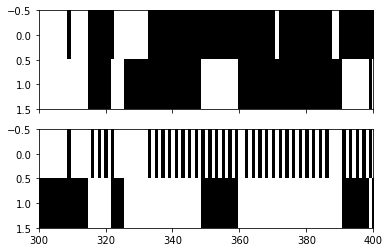

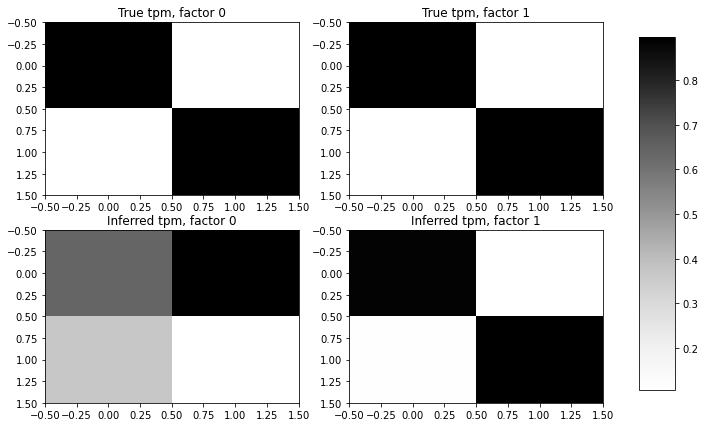

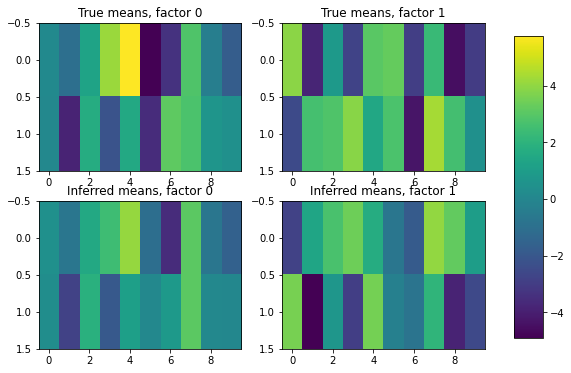

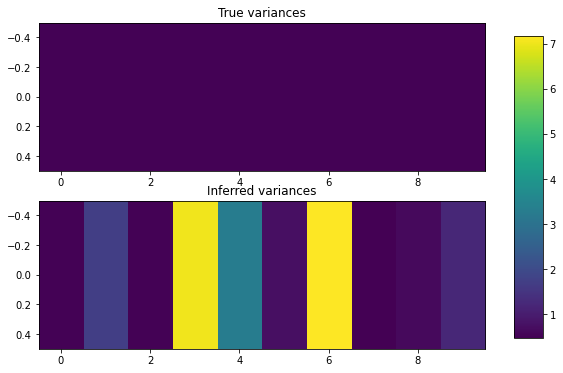

Text(0, 0.5, 'LL')

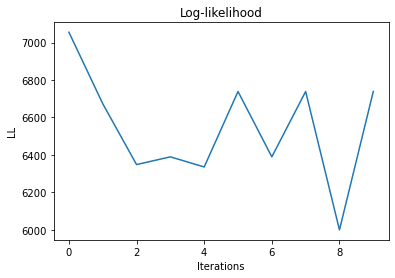

In [21]:
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].imshow(true_states.T, aspect="auto", interpolation="none", cmap="Greys")
axs[1].imshow(samples_fit.T, aspect="auto", interpolation="none", cmap="Greys")
plt.xlim(300, 400)

fig = plt.figure(figsize=(10, 7))
rows = 2
columns = num_factors
values=[params['transition_matrices'].flatten(),params_fit['transition_matrices'].flatten()]
vmin=np.min(values); vmax=np.max(values)
for h in range(num_factors):
          fig.add_subplot(rows, columns, h+1)
          im=plt.imshow(params['transition_matrices'][h], aspect="auto", cmap="Greys")
          plt.title("True tpm, factor "+str(h))
          fig.add_subplot(rows, columns, h+num_factors+1)
          im=plt.imshow(params_fit['transition_matrices'][h], aspect="auto", cmap="Greys")
          plt.title("Inferred tpm, factor "+str(h))
print('True ',params['transition_matrices'])
print('Inferred ',params_fit['transition_matrices'])
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.tight_layout
plt.show()

vmin=np.min([params['means'].flatten(),params_fit['means'].flatten()]); vmax=np.max([params['means'].flatten(),params_fit['means'].flatten()])
fig=plt.figure(figsize=(8,6))
for h in range(num_factors):
          ax = plt.subplot(rows, columns, h+1)
          im=ax.imshow(params['means'][h], aspect="auto", vmin=vmin, vmax=vmax)
          # print('True means factor '+str(h)+' ',str(params['means'][h]))
          ax.set_title("True means, factor "+str(h))
          ax = plt.subplot(rows, columns, h+1+num_factors)
          im=ax.imshow(params_fit['means'][h], aspect="auto", vmin=vmin, vmax=vmax)
          # print('Inferred means factor '+str(h)+' ',str(params_fit['means'][h]))
          ax.set_title("Inferred means, factor "+str(h))
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.tight_layout
plt.show()

values=[params['variances'].flatten(),params_fit['variances'].flatten()]
vmin=np.min(values); vmax=np.max(values)
fig=plt.figure(figsize=(8,6))
ax = plt.subplot(2, 1, 1)
im=ax.imshow(np.expand_dims(params['variances'], axis=0), aspect="auto", vmin=vmin, vmax=vmax)
# print('True variances '+str(params['variances']))
ax.set_title("True variances")
ax = plt.subplot(2,1,2)
im=ax.imshow(np.expand_dims(params_fit['variances'], axis=0), aspect="auto", vmin=vmin, vmax=vmax)
# print('Inferred variances '+str(params_fit['variances']))
ax.set_title("Inferred variances")
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.tight_layout
plt.show()

fig=plt.figure()
plt.plot(ll_tot)
plt.title('Log-likelihood')
plt.xlabel('Iterations')
plt.ylabel('LL')
